In [1]:
import os
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt

from microsim.population import NHANESDirectSamplePopulation

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [2]:
#from microsim.sim_settings import simSettings
#pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
#simSettings.pandarallelFlag = False #with this flag all new population instances will be set to use pandarallel
#seedSequence = np.random.SeedSequence()
#rngStream = np.random.default_rng(seed=seedSequence)

In [3]:
%%time
popSize = 10000
#pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
pop = NHANESDirectSamplePopulation(popSize, 1999)

CPU times: user 3.97 s, sys: 34.9 ms, total: 4 s
Wall time: 4 s


In [4]:
#%%time
#alive, dead = pop.advance_vectorized(18,rng=rngStream) #5m 9s - no recalibration

In [5]:
#pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)

In [6]:
%%time
pop.advance(18) # 1m 50s

CPU times: user 3min 20s, sys: 631 ms, total: 3min 20s
Wall time: 3min 24s


In [7]:
from microsim.risk_factor import DynamicRiskFactorsType

nhanesPop = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
nhanesPop = nhanesPop[~(nhanesPop["timeInUS"]<4)]
nhanesPop = nhanesPop[nhanesPop["year"]==2017]
nhanesPop = nhanesPop[nhanesPop["age"]>=36]

microsimToNhanes = {DynamicRiskFactorsType.SBP.value: "meanSBP",
                    DynamicRiskFactorsType.DBP.value: "meanDBP",
                    DynamicRiskFactorsType.A1C.value: "a1c",
                    DynamicRiskFactorsType.HDL.value: "hdl",
                    DynamicRiskFactorsType.LDL.value: "ldl",
                    DynamicRiskFactorsType.TRIG.value: "trig",
                    DynamicRiskFactorsType.TOT_CHOL.value: "tot_chol",
                    DynamicRiskFactorsType.BMI.value: "bmi",
                    DynamicRiskFactorsType.WAIST.value: "waist",
                    DynamicRiskFactorsType.AGE.value: "age",
                    DynamicRiskFactorsType.ANY_PHYSICAL_ACTIVITY.value: 'anyPhysicalActivity',
                    DynamicRiskFactorsType.CREATININE.value: "serumCreatinine",
                    DynamicRiskFactorsType.ALCOHOL_PER_WEEK: "alcoholPerWeek"}

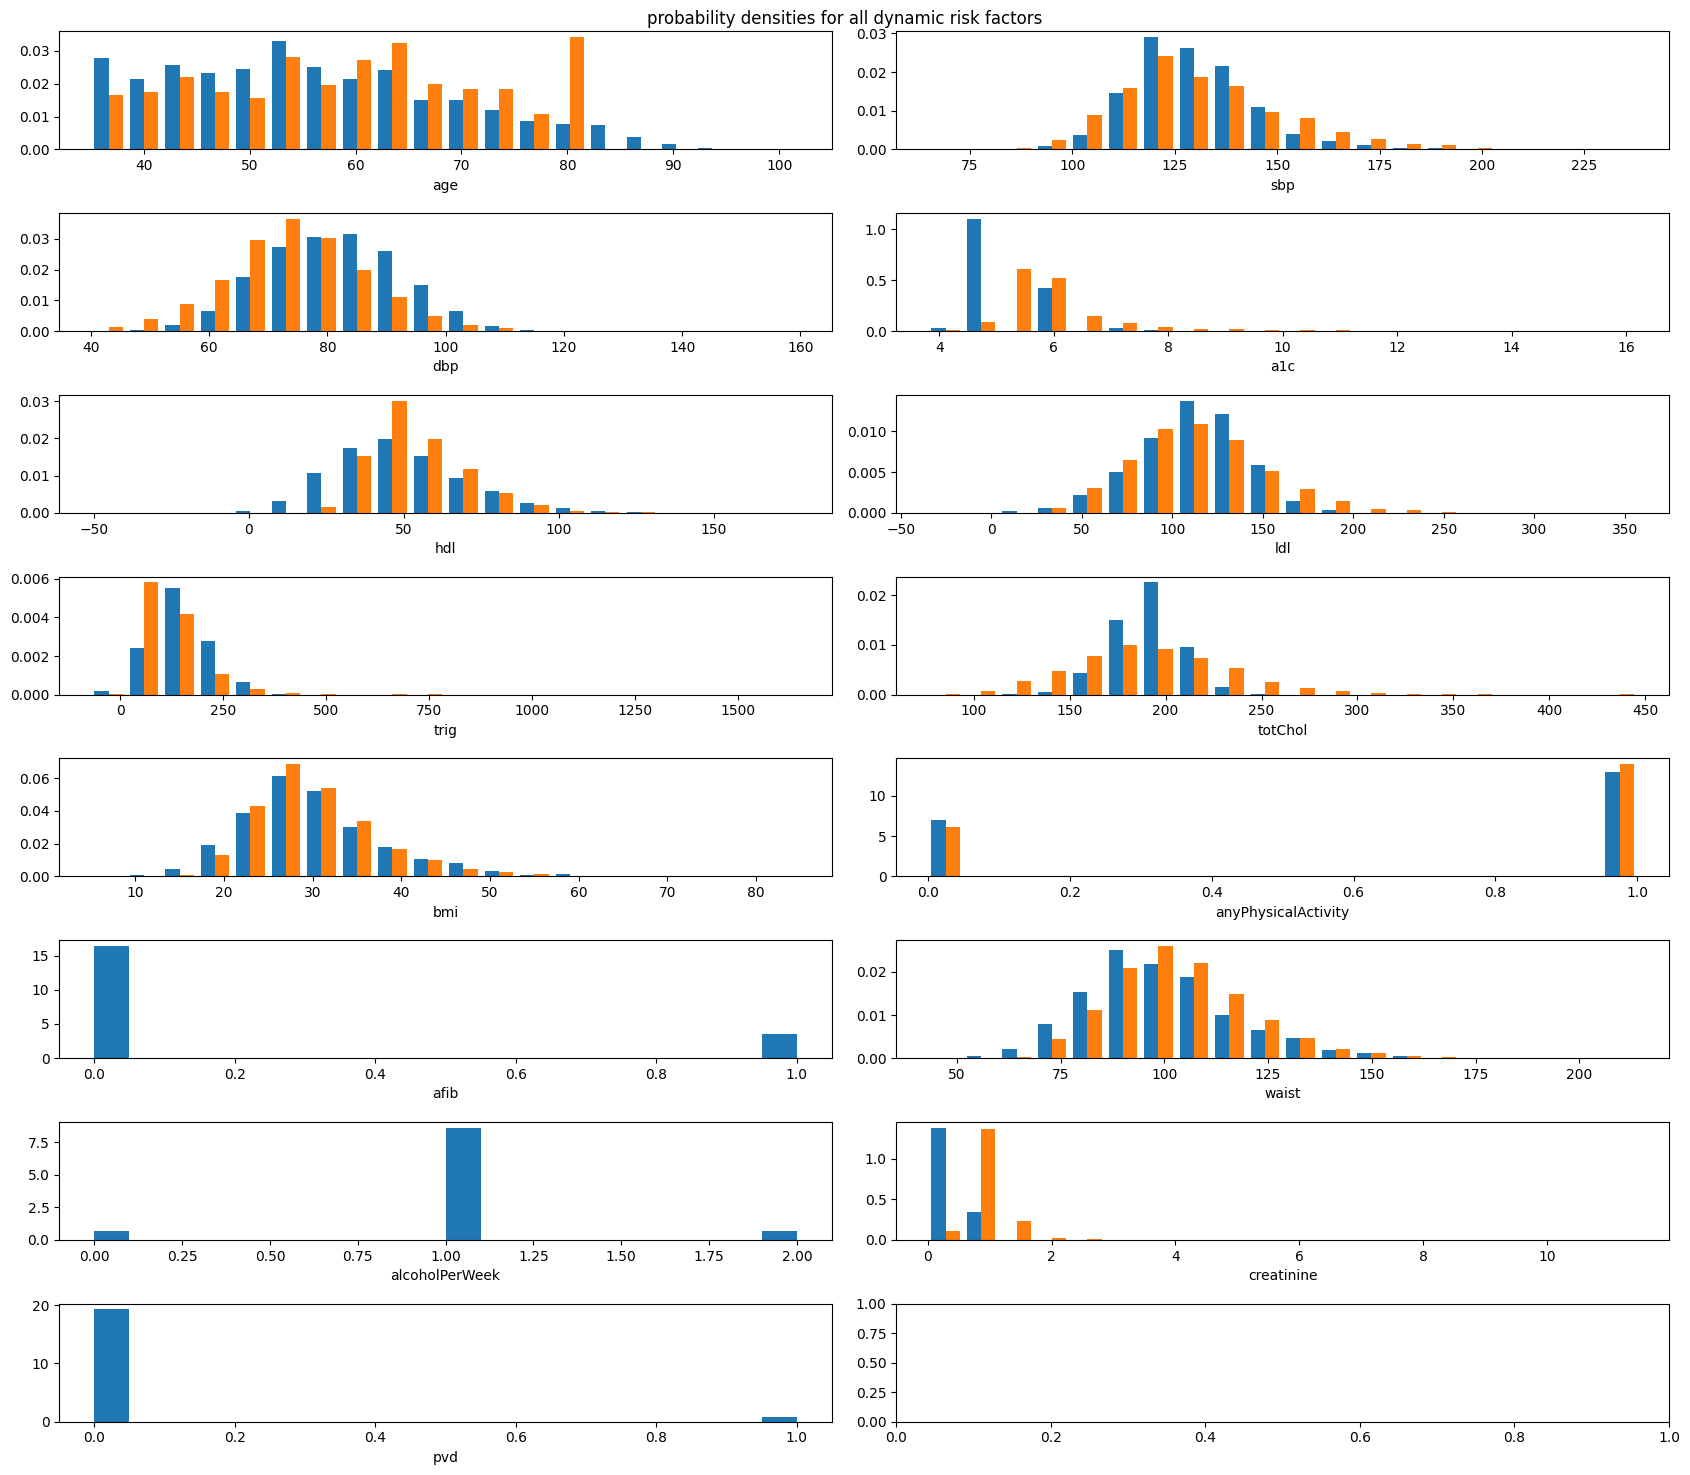

In [8]:
nRows = round(len(DynamicRiskFactorsType)/2)
fig, ax = plt.subplots(nRows, 2, figsize=(17,15))
row=-1
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if i%2==0:
        row += 1
        col = 0
    else:
        col = 1
    if rf.value in microsimToNhanes.keys():
        ax[row,col].hist([rfList, nhanesPop[microsimToNhanes[rf.value]]], bins=20, density=True)
    else:
        ax[row,col].hist(rfList, bins=20, density=True)
    ax[row,col].set_xlabel(rf.value)
    #ax[row,col].set_ylabel("probability density")
plt.suptitle("probability densities for all dynamic risk factors")
#plt.subplots_adjust(wspace=0.5, hspace=0.7)
plt.tight_layout()
plt.show()

In [9]:
space = " "
print("                       sim mean   nha mean    sim sd     nha sd")
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if rf.value in microsimToNhanes.keys():
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {np.mean(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}" + 
             f"{np.std(rfList): 10.2f} {np.std(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}")
    else:
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {space:>9} {np.std(rfList): 10.2f}")

                       sim mean   nha mean    sim sd     nha sd
                 age      55.99      59.43     13.45      13.07
                 sbp     129.68     131.21     15.17      20.65
                 dbp      81.43      73.77     11.76      11.94
                 a1c       5.31       6.05      0.59       1.20
                 hdl      49.27      53.65     21.57      16.13
                 ldl     112.16     114.03     30.06      37.59
                trig     153.93     121.37     69.72      91.21
             totChol     191.55     190.69     17.82      42.14
                 bmi      29.70      30.12      8.26       7.15
 anyPhysicalActivity       0.65       0.69      0.48       0.46
                afib       0.18                 0.38
               waist      99.25     102.95     18.40      16.40
      alcoholPerWeek       1.00                 0.37
          creatinine       0.23       0.94      0.62       0.49
                 pvd       0.04                 0.19


In [10]:
from microsim.outcome import OutcomeType
outcomes = [OutcomeType.MI, OutcomeType.STROKE, OutcomeType.DEATH, 
            OutcomeType.CARDIOVASCULAR, OutcomeType.NONCARDIOVASCULAR, OutcomeType.DEMENTIA]
standardizedRates = list(map(lambda x: pop.calculate_mean_age_sex_standardized_incidence(x, 2016), outcomes))
standardizedRatesBlack = list(map(
                           lambda x: pop.calculate_mean_age_sex_standardized_incidence(x,2016, lambda y: y._black), 
                           outcomes))
print("standardized rates (per 100,000)   -all       -black   ")
for i in range(len(outcomes)):
    print(f"{outcomes[i].value:>30} {standardizedRates[i]:> 10.1f} {standardizedRatesBlack[i]:> 10.1f}") 

standardized rates (per 100,000)   -all       -black   
                            mi      231.9      180.6
                        stroke      157.5      297.0
                         death      871.3     1079.1
                            cv      389.4      477.6
                         noncv      824.0     1002.8
                      dementia    35674.5    42244.0


In [11]:
dementiaIncidentRate = pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)

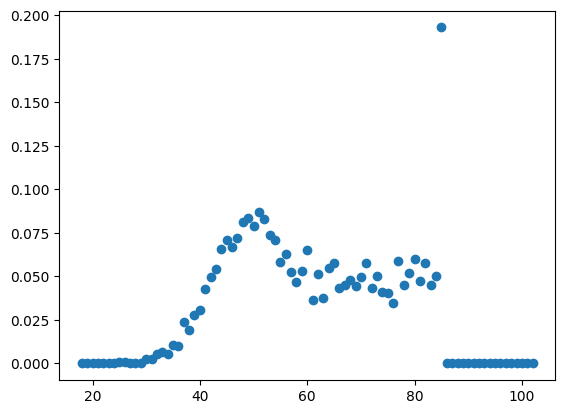

In [12]:
plt.scatter(dementiaIncidentRate.keys(), dementiaIncidentRate.values())
plt.show()

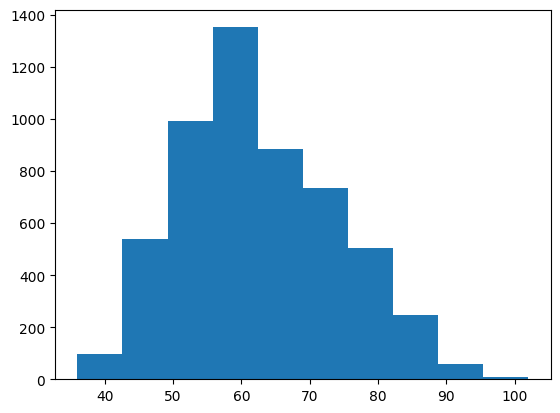

In [13]:
ab = list(map(lambda y: (y._age[-1], len(y._outcomes[OutcomeType.DEMENTIA])>0), 
              list(filter(lambda x: x.is_alive, pop._people))))
ab = list(filter(lambda x: x[1]==True, ab))
ab = [int(x[0]) for x in ab]
plt.hist(ab)
plt.show()